## S&P 500 Stocks

The Standard and Poor's 500 or S&P 500 is the most famous financial benchmark in the world.
This stock market index tracks the performance of 500 large companies listed on stock exchanges in the United States. As of December 31, 2020, more than $5.4 trillion was invested in assets tied to the performance of this index. The dataset can be viewed here. 

In [ ]:
import pandas as pd
import numpy as np
import os

df = pd.read_csv('/kaggle/input/sp-500-stocks/sp500_stocks.csv')

df.info()

In [14]:
df.describe()

,Adj Close,Close,High,Low,Open,Volume,Symbol_encoded,Daily_Return,MA50,Volatility
count,1.875687e+06,1.875687e+06,1.875687e+06,1.875687e+06,1.875687e+06,1.875687e+06,1.875687e+06,1.875687e+06,1.875687e+06,1.875687e+06
mean,9.405520e+01,1.017015e+02,1.028014e+02,1.005448e+02,1.016832e+02,6.759770e+06,2.510000e+02,4.965365e-04,9.390133e+01,5.008830e+00
std,2.063537e+02,2.065661e+02,2.089260e+02,2.041256e+02,2.064872e+02,3.222673e+07,1.452033e+02,2.355672e-02,2.025084e+02,1.925610e+01
min,2.036070e-01,2.220000e-01,2.262500e-01,2.162500e-01,2.180000e-01,0.000000e+00,0.000000e+00,-9.985533e-01,2.270584e-01,0.000000e+00
25%,2.990748e+01,3.600000e+01,3.638717e+01,3.558812e+01,3.600000e+01,1.065000e+06,1.250000e+02,-7.364961e-03,3.025215e+01,1.072027e+00
50%,5.349667e+01,6.244000e+01,6.305000e+01,6.176000e+01,6.242000e+01,2.200900e+06,2.510000e+02,0.000000e+00,5.384771e+01,2.027771e+00
75%,9.810000e+01,1.082621e+02,1.093900e+02,1.070900e+02,1.082500e+02,4.768600e+06,3.770000e+02,8.884146e-03,9.810880e+01,4.198238e+00
max,9.924400e+03,9.924400e+03,9.964770e+03,9.794000e+03,9.914170e+03,3.692928e+09,5.020000e+02,4.035114e+00,9.389525e+03,2.144589e+03


In [15]:
df.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Symbol_encoded,Daily_Return,MA50,Volatility
0,2010-01-04,MMM,44.016731,69.414719,69.774246,69.122070,69.473244,3640265.0,313,0.000000,53.847708,2.027771
1,2010-01-05,MMM,43.741024,68.979935,69.590302,68.311035,69.230766,3405012.0,313,-0.006264,53.847708,2.027771
2,2010-01-06,MMM,44.361351,69.958191,70.735786,69.824417,70.133781,6301126.0,313,0.014182,53.847708,2.027771
3,2010-01-07,MMM,44.393166,70.008362,70.033447,68.662209,69.665550,5346240.0,313,0.000717,53.847708,2.027771
4,2010-01-08,MMM,44.705978,70.501671,70.501671,69.648827,69.974915,4073337.0,313,0.007046,53.847708,2.027771


## Data Preprocessing

In [16]:
from sklearn.preprocessing import LabelEncoder

# encoding the Symbol column
le = LabelEncoder()
df['Symbol_encoded'] = le.fit_transform(df['Symbol'])

**Because we are developing a prediction model, we are going to do some feature engineering.**

This code performs feature engineering by creating three new columns:
* **'Daily_Return'** - the percentage change in the adjusted closing price, calculated using the .pct_change() method.
* **'MA50'** - the 50-day moving average of the adjusted close price, which smooths out short-term fluctuations.
* **'Volatility'** - the 50-day rolling standard deviation, used as a measure of price volatility over time.

In [17]:
df['Daily_Return'] = df['Adj Close'].pct_change()
df['MA50'] = df['Adj Close'].rolling(window=50).mean()  # 50-day moving average
df['Volatility'] = df['Adj Close'].rolling(window=50).std()  # 50-day volatility

**Let's define our features.**

In [18]:
features = ['Open', 'High', 'Low', 'Volume', 'Symbol_encoded', 'MA50', 'Volatility', 'Daily_Return']
target = 'Adj Close'

**Below cell shows which variables have how many null values and changes them with median value.**

* Handling missing values is the next step of the process.
* The upcoming code will check for null values and replace them with the **median value**, the best practice for dealing with missing data.

In [19]:
# checked whether there are any missing values
print(df.isnull().sum())

# change missing values only for numeric variable
numeric_columns = df.select_dtypes(include=[np.number]).columns

# fill missing values with the median for each column
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

Date               0
Symbol             0
Adj Close          0
Close              0
High               0
Low                0
Open               0
Volume             0
Symbol_encoded     0
Daily_Return       1
MA50              49
Volatility        49
dtype: int64


In [20]:
# use 20% of data for testing
split_point = int(len(df) * 0.8)
train_df = df[:split_point]
test_df = df[split_point:]

# train/test split
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

**XGBoost, Random Forest Regressor and Support Vector Regression (SVR) are evaluated.**

**Evaluation metrics:**
* **MAE (Mean Absolute Error):** Measures the average magnitude of errors.
* **MSE (Mean Squared Error):** Measures the squared differences between predicted and actual values.

**Visualization of actual prices would help to compare how well models performed.**

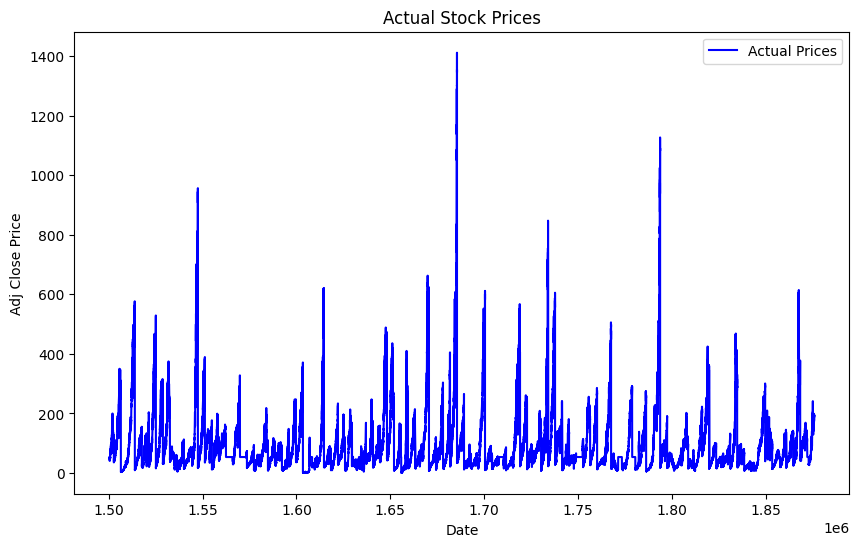

In [21]:
# visualization of actual stock prices
import matplotlib.pyplot as plt

# plot actual stock prices
plt.figure(figsize=(10,6))
plt.plot(test_df.index, y_test, label='Actual Prices', color='blue')
plt.title('Actual Stock Prices')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()

# XGBoost

**XGBoost is well-known for its efficiency and performance in regression tasks, making it a good choice for this dataset.**

* This code initializes the XGBoost regressor with specific hyperparameters: **100 estimators and a learning rate of 0.1.**
* The model is then trained using the training data **(X_train, y_train)** and predictions are made on the **test data (X_test).**
* The performance of the model is evaluated using **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)**, both of which are printed.

In [22]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)

# train the model
xgb_model.fit(X_train, y_train)

# make predictions
y_pred = xgb_model.predict(X_test)

# model evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 91.31389433378781
Mean Absolute Error: 3.1051675656975832


**Visualization of XGBoost**

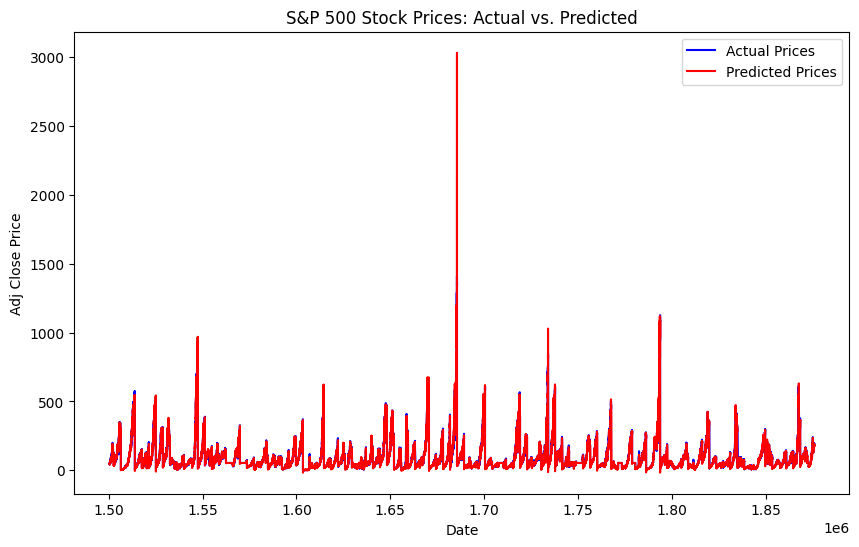

In [23]:
import matplotlib.pyplot as plt

# plot the actual vs predicted prices
plt.figure(figsize=(10,6))
plt.plot(test_df.index, y_test, label='Actual Prices', color='blue')
plt.plot(test_df.index, y_pred, label='Predicted Prices', color='red')
plt.title('S&P 500 Stock Prices: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()

**Evaluation of XGBoost:**
* While the MSE isn't too high, it might indicate that the **model is not capturing extreme price spikes or falls well**.
* **MAE of the model is by about 2.99** units of the adjusted closing price. Given that stock prices in the dataset can vary widely (as seen in the plot), **an average error of ~3 units could be acceptable**, depending on the range of stock prices.
* There seems to be a significant **misalignment** in capturing spikes and dips in prices. The predicted prices (red) consistently overshoot or undershoot during large price swings, which can lead to high error metrics.
* **XGBoost**, while powerful, might be having difficulty capturing sudden and extreme price changes or volatility.

## The mapped Company Symbol and values are as follows

In [32]:
symbol_mapping = dict(zip(le.transform(le.classes_), le.classes_)) 

# Display the mapping for reference
print("Symbol Mapping (Encoded to Actual):")
print(symbol_mapping)

Symbol Mapping (Encoded to Actual):
{0: 'A', 1: 'AAPL', 2: 'ABBV', 3: 'ABNB', 4: 'ABT', 5: 'ACGL', 6: 'ACN', 7: 'ADBE', 8: 'ADI', 9: 'ADM', 10: 'ADP', 11: 'ADSK', 12: 'AEE', 13: 'AEP', 14: 'AES', 15: 'AFL', 16: 'AIG', 17: 'AIZ', 18: 'AJG', 19: 'AKAM', 20: 'ALB', 21: 'ALGN', 22: 'ALL', 23: 'ALLE', 24: 'AMAT', 25: 'AMCR', 26: 'AMD', 27: 'AME', 28: 'AMGN', 29: 'AMP', 30: 'AMT', 31: 'AMTM', 32: 'AMZN', 33: 'ANET', 34: 'ANSS', 35: 'AON', 36: 'AOS', 37: 'APA', 38: 'APD', 39: 'APH', 40: 'APTV', 41: 'ARE', 42: 'ATO', 43: 'AVB', 44: 'AVGO', 45: 'AVY', 46: 'AWK', 47: 'AXON', 48: 'AXP', 49: 'AZO', 50: 'BA', 51: 'BAC', 52: 'BALL', 53: 'BAX', 54: 'BBY', 55: 'BDX', 56: 'BEN', 57: 'BF-B', 58: 'BG', 59: 'BIIB', 60: 'BK', 61: 'BKNG', 62: 'BKR', 63: 'BLDR', 64: 'BLK', 65: 'BMY', 66: 'BR', 67: 'BRK-B', 68: 'BRO', 69: 'BSX', 70: 'BWA', 71: 'BX', 72: 'BXP', 73: 'C', 74: 'CAG', 75: 'CAH', 76: 'CARR', 77: 'CAT', 78: 'CB', 79: 'CBOE', 80: 'CBRE', 81: 'CCI', 82: 'CCL', 83: 'CDNS', 84: 'CDW', 85: 'CE', 86: 'CEG

## Taking 1 data from test data to visualize and test the value

In [39]:
# Select one data point from X_test
single_sample = X_test.iloc[0:1]
actual_value = y_test.iloc[0]

# Decode the company symbol from `Symbol_encoded`
encoded_value = single_sample['Symbol_encoded'].values[0]
decoded_symbol = symbol_mapping.get(encoded_value, "Unknown")

print(f"Decoded Company Symbol: {decoded_symbol}")
print(f"Data For testing: {single_sample}")

Decoded Company Symbol: RVTY
Data For testing:               Open       High        Low    Volume  Symbol_encoded       MA50  \
1500549  51.049999  52.290001  51.049999  606700.0             406  48.700299   

         Volatility  Daily_Return  
1500549    2.555173      0.026724  


So the selected data belongs to RVTY company.

Actual Value:  50.80609130859375
Single Prediction:  49.510124


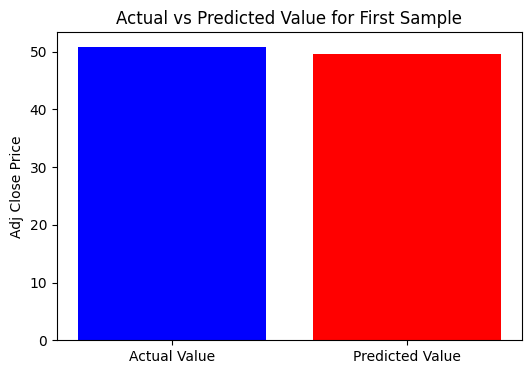

In [42]:
# Predict the Adj Close price for the selected sample
single_prediction = xgb_model.predict(single_sample)[0]
print("Actual Value: ", actual_value)
print("Single Prediction: ",single_prediction)

# Plot the predicted value against the actual value
plt.figure(figsize=(6, 4))
plt.bar(['Actual Value', 'Predicted Value'], [actual_value, single_prediction], color=['blue', 'red'])
plt.title("Actual vs Predicted Value for First Sample")
plt.ylabel("Adj Close Price")
plt.show()

We can see the prediction of model is very nice which is nery close to actual data.

# Random Forest Regressor
**Random Forests are particularly useful for regression tasks involving complex datasets, as they can capture non-linear relationships.**

* The model is initialized with **50 estimators** and **a maximum depth of 10 to limit overfitting.**
* After fitting the model to the training data (X_train, y_train), predictions are made on the test set (X_test).
* The **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)** are calculated and printed to evaluate the model's performance.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# initialize the RandomForest Regressor
rf_model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)

# fit the model
rf_model.fit(X_train, y_train)

# make predictions
y_pred_rf = rf_model.predict(X_test)

# calculate evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest Mean Absolute Error: {mae_rf}')

**Visualization of Random Forest Regressor**

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(test_df.index, y_test, label='Actual Prices', color='blue')
plt.plot(test_df.index, y_pred_rf, label='Predicted Prices (Random Forest)', color='red')
plt.title('Actual vs Predicted Stock Prices (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()

**Evaluation of Random Forest Regressor:**
* A lower MSE suggests that the model is now performing better, particularly in handling the overall variability of stock prices.
* The MAE of 2.46 means that, on average, the model's predictions are off by about 2.46 units from the actual Adj Close price. **This is a reasonable MAE**, especially given the complexity and variability of stock price data.
* The plot shows that the predicted prices (red line) follow the actual prices (blue line) closely in most areas, but there are still discrepancies during the spikes. The model is **struggling to capture the extreme price spikes, which is common in stock price predictions**, especially when prices fluctuate drastically.

# Support Vector Regression (SVR)
**SVR is robust in capturing non-linear patterns, especially with the RBF kernel, and it often performs well on datasets with noise.**

* This code uses the StandardScaler from sklearn to scale both the **features (X)** and **the target variable (y).**
* The StandardScaler standardizes features by removing the mean and scaling to unit variance, which is necessary for models like SVR.
* The scaler is fitted on the training data and then used to transform the features and target to the appropriate scale.

**SVR requires the data to be scaled since it is sensitive to the magnitude of the features.**

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# define and fit scalers for X (features) and y (target)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# fit the scaler on the full training data first
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

* In below cell, **10% of the data is sampled** for training the SVR model to **reduce computational cost.**
* The features and target are scaled using the previously fitted scalers.
* An SVR model is initialized with the RBF kernel, **C=100, gamma=0.1, and epsilon=0.1.**
* The model is then trained on the sampled data using these hyperparameters.

In [ ]:
# use 10% of the data for training SVR (sampling)
X_train_sample = X_train.sample(frac=0.1, random_state=42)
y_train_sample = y_train.sample(frac=0.1, random_state=42)

X_train_scaled_sample = scaler_X.transform(X_train_sample)
y_train_scaled_sample = scaler_y.transform(y_train_sample.values.reshape(-1, 1))

# train the SVR model on the sample
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train_scaled_sample, y_train_scaled_sample.ravel())

* The test data (X_test) is scaled using the previously fitted scaler.
* Predictions are made on the scaled test data using the SVR model.
* The predicted values are **inverse transformed** back to the original scale using the scaler.
* The performance of the SVR model is evaluated using two metrics: **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE),** which are printed for review.

In [ ]:
# scale the test data
X_test_scaled = scaler_X.transform(X_test) 

# make predictions on the scaled test data
y_pred_scaled = svr_model.predict(X_test_scaled)

y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# calculate evaluation metrics (MSE, MAE)
mse_svr = mean_squared_error(y_test, y_pred)
mae_svr = mean_absolute_error(y_test, y_pred)

print(f'SVR Mean Squared Error: {mse_svr}')
print(f'SVR Mean Absolute Error: {mae_svr}')

**Visualization of SVR**

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(test_df.index, y_test, label='Actual Prices', color='blue')
plt.plot(test_df.index, y_pred, label='Predicted Prices (SVR)', color='red')
plt.title('Actual vs Predicted Stock Prices (SVR)')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.show()

**Evaluation of Support Vector Regression:**

* The **MSE of 686.30 is quite high**. This points that the model that **is not** capturing the patterns in the data well.
* The **MAE of 12.18 means that**, for stock price data, **the model is struggling to make accurate predictions**, particularly with **extreme values** or **sharp changes** in stock prices.
* The plot clearly shows a **large deviation between the predicted prices (red) and actual prices (blue).** **Sharp spikes** and **volatility** are not well captured by the SVR model. It tends to **overestimate and exaggerate the peaks.**